# Análisis de la etapa de generación de medios

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  
import plotly.express as px

## Armado del dataset

En este paso parsearemos los archivos para obtener estadísticas sobre el tiempo que tarda cada ejecución de una función, sobre la memoria usada, el uso de CPU. Con esto buscamos identificar:
- Qué funciones son las que consumen mayor cantidad de memoria
- Qué funciones son las que tienen un mayor tiempo de procesamiento
- Qué funciones son las que son invocadas una mayor cantidad de veces

Una vez identificados estos puntos de análisis podemos proponer soluciones para mejorar estas estadísticas.

In [102]:
def get_function_name(function_name):
    return function_name[10:].rsplit(".c")[0]

In [103]:
relations = {
    "Py_kgeneration": ['generate', 'fftma2'],
    "generate": ["gasdev"],
    "gasdev": ["ran2"],
    "fftma2": ["covariance", "fourt", "prebuild_gwn"]
}

In [132]:
def get_data(file_name):
    data = []
    row = {}

    with open(file_name) as log_file:
        lines = log_file.readlines()
        for line in lines:
            split_line = line.split()
                
            if "USED" not in split_line and "ELAPSED" not in split_line and "CPU" not in split_line: continue
    
            if "CPU" in split_line:
                idx_cpu = split_line.index("CPU") + 1
                idx_per = idx_cpu + 1
                row["cpu"] = row.get('CPU', [])
                row["cpu"].append(float(split_line[idx_per].rsplit("%")[0]))
                continue
                
            idx_used_mem = split_line.index("USED") + 4
            idx_elapsed = split_line.index("ELAPSED") + 2
            
            function_name = get_function_name(split_line[2])
                        
            used_virtual_mem = float(split_line[idx_used_mem])
            elapsed = float(split_line[idx_elapsed].rsplit(",")[0])

            row["function"] = function_name
            row["memory"] = used_virtual_mem 
            row["time"] = elapsed
            if "cpu" in row:
                row["cpu"] = sum(row["cpu"]) / len(row["cpu"])
            data.append(row)
            row = {}
            
    return data

In [105]:
def create_df(file_name):
    data = get_data(file_name)
    df = pd.DataFrame(data)
    return df.groupby(['function']).agg({'time': ['min', 'max', 'mean', 'sum', 'count'], 'memory': ['min', 'max', 'median'], 'cpu': ['min', 'max', 'mean']})

In [106]:
def analyze(file_name):
    df_grouped = create_df(file_name)
    return df_grouped.sort_values(by=('time', 'sum'), ascending=False)                

In [107]:
def merge_dfs(dfs):
    functions = ['Py_kgeneration', 'generate', 'fftma2', 'covariance', 'gasdev', 'fourt', 'cov_value', 'ran2', 'build_real', 'prebuild_gwn', 'clean_real', 'cgrid', 'length', 'maxfactor']
    df_final = pd.concat(dfs, join='inner').sort_values(by=('time', 'sum'), ascending=False) 

    memory_min, memory_max, memory_median = [], [], []
    time_min, time_max, time_mean, time_sum, time_count = [], [], [], [], []
    cpu_min, cpu_max, cpu_mean = [], [], []

    for function in functions:
        memory_min.append(df_final.loc[function, ('memory', 'min')].min())
        time_min.append(df_final.loc[function, ('time', 'min')].min())
        cpu_min.append(df_final.loc[function, ('cpu', 'min')].min())
        memory_max.append(df_final.loc[function, ('memory', 'max')].max())
        time_max.append(df_final.loc[function, ('time', 'max')].max())
        cpu_max.append(df_final.loc[function, ('cpu', 'max')].max())
        time_mean.append(df_final.loc[function, ('time', 'mean')].mean())
        cpu_mean.append(df_final.loc[function, ('time', 'mean')].mean())
        time_sum.append(df_final.loc[function, ('time', 'sum')].sum())
        time_count.append(df_final.loc[function, ('time', 'count')].sum())
        try:
            memory_median.append(df_final.loc[function, ('memory', 'median')].median())
        except:
            memory_median.append(df_final.loc[function, ('memory', 'median')])
        
    df = pd.DataFrame({('memory', 'min'): memory_min, ('memory', 'max'): memory_max, ('memory', 'median'): memory_median, ('time', 'min'): time_min, ('time', 'max'): time_max, ('time', 'mean'): time_mean, ('time', 'sum'): time_sum, ('time', 'count'): time_count, ('cpu', 'min'): cpu_min, ('cpu', 'max'): cpu_max, ('cpu', 'mean'): cpu_mean})

    df.index = functions
    df.index.name = 'function'
    return df

In [108]:
def analyze(file_names):
    if len(file_names) == 1:
        df_grouped = create_df(file_names[0])
        return df_grouped.sort_values(by=('time', 'sum'), ascending=False)
    else:
        dfs = []
        for file_name in file_names:
            print("Executing file {}".format(file_name))
            df = create_df(file_name)
            dfs.append(df)
        return merge_dfs(dfs)

In [109]:
def plot_pie(df, function, plt):
    
    labels = relations[function].copy()
    total = df.loc[function][('time', 'sum')]
    sizes = []
    explode = []

    rest = total

    for func in labels:
        func_duration = df.loc[func][('time', 'sum')]
        rest -= func_duration
        value = func_duration/ total
        sizes.append(value)
        explode.append(0 if value > 0.01 else 0.1)

    labels.append("other")
    sizes.append(rest/total)
    sizes = np.array(sizes)
    porcent = 100.*sizes/sizes.sum()
    explode.append(0 if rest/total > 0.01 else 0.1)

    plt.set_title(function)

    patches, texts = plt.pie(sizes, startangle=90, radius=1.2)
    labels_formated = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]

    sort_legend = True
    if sort_legend:
        patches, labels_formated, dummy =  zip(*sorted(zip(patches, labels_formated, sizes),
                                              key=lambda x: x[2],
                                              reverse=True))

    plt.legend(patches, labels_formated, loc='upper left', bbox_to_anchor=(-0.1, 1.),
               fontsize=8)
    
    plt.axis('equal')

def plot_analysis(df):
    fig, axs = plt.subplots(2, 2, dpi=100, figsize=(6, 6))
    fig.suptitle('Time comparisons')
    functions = list(relations.keys())
    for i in range(2):
        for j in range(2):
            plot_pie(df,functions[2*i + j], axs[i, j])
    

In [117]:
parents = {
    "Py_kgeneration": "",
    "generate": "Py_kgeneration",
    "gasdev": "generate",
    "fftma2":  "Py_kgeneration",
    "covariance": "fftma2",
    "fourt": "fftma2",
    "prebuild_gwn": "fftma2",
    "ran2": "gasdev",
    "cov_value": "covariance",
}

def plot_treemap(df):
    df["parent"] = [parents.get(item, "") for item in df.index]
    df2 = df.reset_index()
    df2["time_sum"] = df2[[("time", "sum")]]
    df2 = df2[["function", "parent", "time_sum"]]
    fig3 = px.treemap(df2, names='function', parents='parent',values='time_sum', color="parent", title="Time treemap")
    fig3.show()

## N = 8

In [118]:
df = analyze(['log_8-aa'])
df

time                                     memory       \
                     min       max      mean       sum count    min  max   
function                                                                   
Py_kgeneration  0.573509  0.573509  0.573509  0.573509     1    1.3  1.3   
generate        0.432266  0.432266  0.432266  0.432266     1    0.8  0.8   
gasdev          0.000080  0.023294  0.000620  0.317450   512   -0.5  0.2   
fftma2          0.138753  0.138753  0.138753  0.138753     1    0.5  0.5   
covariance      0.135896  0.135896  0.135896  0.135896     1    0.5  0.5   
ran2            0.000077  0.001476  0.000132  0.092725   702    0.0  0.2   
cov_value       0.000080  0.000154  0.000084  0.058473   700   -0.2  0.2   
cgrid           0.001218  0.001218  0.001218  0.001218     1    0.0  0.0   
length          0.000266  0.000268  0.000267  0.000802     3    0.0  0.0   
fourt           0.000122  0.000138  0.000130  0.000391     3    0.0  0.0   
maxfactor       0.000079  0.000080  0.000079  0.000238     3    0.0  0.0   
build_real      0.000104  0.000104  0.000104  0.000104     1    0.0  0.0   
prebuild_gwn    0.000084  0.000084  0.000084  0.000084     1    0.0  0.0   
clean_real      0.000082  0.000082  0.000082  0.000082     1    0.0  0.0   

                              cpu                          
               median         min         max        mean  
function                                                   
Py_kgeneration    1.3   19.612195   19.612195   19.612195  
generate          0.8   20.100000   20.100000   20.100000  
gasdev            0.0    0.000000  100.100000    0.589648  
fftma2            0.5   18.850000   18.850000   18.850000  
covariance        0.5   13.433333   13.433333   13.433333  
ran2              0.0    0.000000  100.100000    0.142593  
cov_value         0.0    0.000000    0.100000    0.000714  
cgrid             0.0  100.100000  100.100000  100.100000  
length            0.0    0.000000    0.000000    0.000000  
fourt             0.0    0.000000    0.000000    0.000000  
maxfactor         0.0    0.000000    0.000000    0.000000  
build_real        0.0    0.000000    0.000000    0.000000  
prebuild_gwn      0.0    0.000000    0.000000    0.000000  
clean_real        0.0    0.000000    0.000000    0.000000

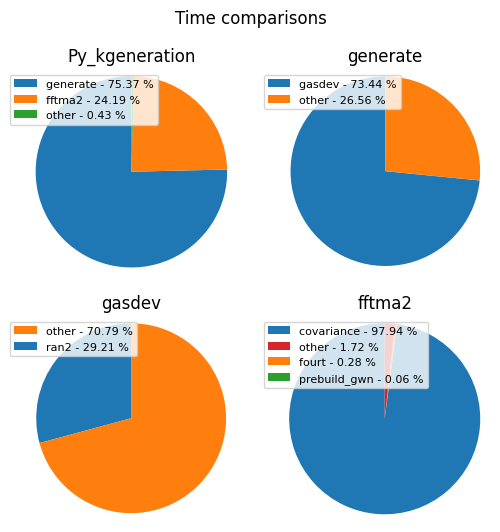

In [119]:
plot_analysis(df)

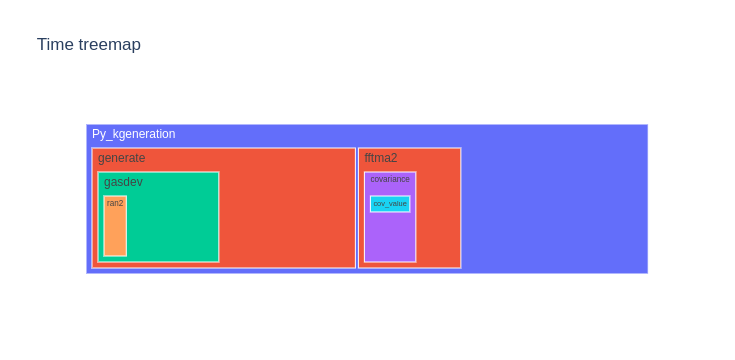

In [120]:
plot_treemap(df)

## N = 16

In [121]:
df = analyze(['log_16-aa'])
df

time                                     memory       \
                     min       max      mean       sum count    min  max   
function                                                                   
Py_kgeneration  2.673944  2.673944  2.673944  2.673944     1   -3.0 -3.0   
generate        1.986983  1.986983  1.986983  1.986983     1   -4.1 -4.1   
gasdev          0.000080  0.023351  0.000361  1.479755  4096   -3.1  0.5   
fftma2          0.684455  0.684455  0.684455  0.684455     1    1.1  1.1   
covariance      0.680862  0.680862  0.680862  0.680862     1    1.1  1.1   
ran2            0.000077  0.001325  0.000088  0.464902  5268   -1.6  0.5   
cov_value       0.000080  0.000145  0.000082  0.293202  3564   -1.3  0.2   
cgrid           0.001203  0.001203  0.001203  0.001203     1    0.0  0.0   
fourt           0.000328  0.000441  0.000371  0.001112     3    0.0  0.0   
length          0.000266  0.000268  0.000267  0.000802     3    0.0  0.0   
maxfactor       0.000080  0.000080  0.000080  0.000240     3    0.0  0.0   
build_real      0.000135  0.000135  0.000135  0.000135     1    0.0  0.0   
prebuild_gwn    0.000100  0.000100  0.000100  0.000100     1    0.0  0.0   
clean_real      0.000083  0.000083  0.000083  0.000083     1    0.0  0.0   

                             cpu                         
               median        min         max       mean  
function                                                 
Py_kgeneration   -3.0   7.477049    7.477049   7.477049  
generate         -4.1  10.269492   10.269492  10.269492  
gasdev            0.0   0.000000  100.100000   0.271851  
fftma2            1.1   0.100000    0.100000   0.100000  
covariance        1.1   0.100000    0.100000   0.100000  
ran2              0.0   0.000000    0.100000   0.000816  
cov_value         0.0   0.000000    0.100000   0.000898  
cgrid             0.0   0.000000    0.000000   0.000000  
fourt             0.0   0.000000    0.000000   0.000000  
length            0.0   0.000000    0.000000   0.000000  
maxfactor         0.0   0.000000    0.000000   0.000000  
build_real        0.0   0.000000    0.000000   0.000000  
prebuild_gwn      0.0   0.000000    0.000000   0.000000  
clean_real        0.0   0.000000    0.000000   0.000000

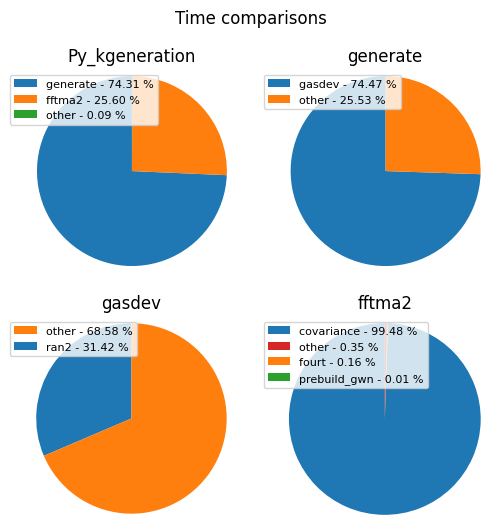

In [122]:
plot_analysis(df)

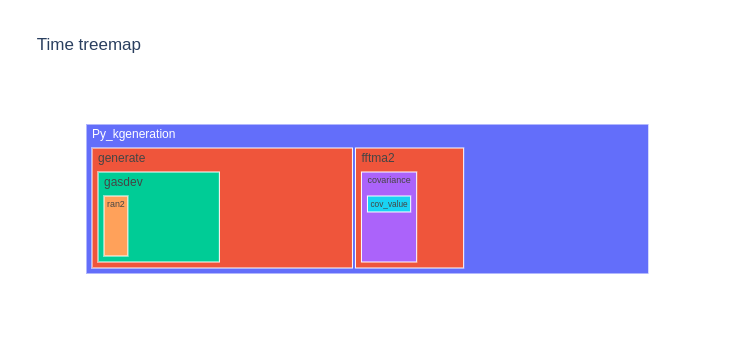

In [123]:
plot_treemap(df)

## N = 32

In [124]:
df = analyze(['log_32-aa'])
df

time                                         memory  \
                      min        max       mean        sum  count    min   
function                                                                   
Py_kgeneration  19.763131  19.763131  19.763131  19.763131      1   73.1   
generate        14.644248  14.644248  14.644248  14.644248      1   31.7   
gasdev           0.000080   0.023625   0.000332  10.893141  32768   -3.1   
fftma2           5.116014   5.116014   5.116014   5.116014      1   41.4   
covariance       5.103886   5.103886   5.103886   5.103886      1   41.0   
ran2             0.000077   0.001241   0.000083   3.453295  41552   -2.4   
cov_value        0.000080   0.000254   0.000089   2.195379  24624   -2.4   
fourt            0.002385   0.003391   0.002721   0.008164      3    0.0   
cgrid            0.001590   0.001590   0.001590   0.001590      1    0.0   
length           0.000270   0.000458   0.000395   0.001185      3    0.0   
build_real       0.000536   0.000536   0.000536   0.000536      1    0.0   
maxfactor        0.000080   0.000082   0.000081   0.000405      5    0.0   
clean_real       0.000258   0.000258   0.000258   0.000258      1    0.0   
prebuild_gwn     0.000236   0.000236   0.000236   0.000236      1    0.4   

                                   cpu                         
                 max median        min         max       mean  
function                                                       
Py_kgeneration  73.1   73.1  46.861856   46.861856  46.861856  
generate        31.7   31.7  60.993471   60.993471  60.993471  
gasdev           2.5    0.0   0.000000  100.100000   1.942624  
fftma2          41.4   41.4   6.226482    6.226482   6.226482  
covariance      41.0   41.0   6.238614    6.238614   6.238614  
ran2             1.2    0.0   0.000000  100.100000   0.405054  
cov_value        1.7    0.0   0.000000  100.100000   0.017077  
fourt            0.0    0.0   0.000000    0.100000   0.033333  
cgrid            0.0    0.0   0.000000    0.000000   0.000000  
length           0.0    0.0   0.000000    0.000000   0.000000  
build_real       0.0    0.0   0.000000    0.000000   0.000000  
maxfactor        0.0    0.0   0.000000    0.000000   0.000000  
clean_real       0.0    0.0   0.000000    0.000000   0.000000  
prebuild_gwn     0.4    0.4   0.000000    0.000000   0.000000

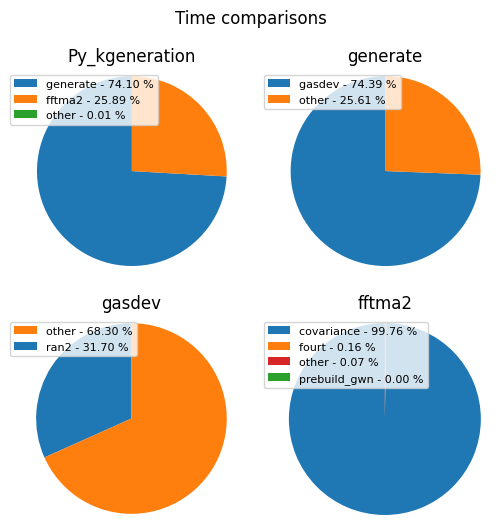

In [125]:
plot_analysis(df)

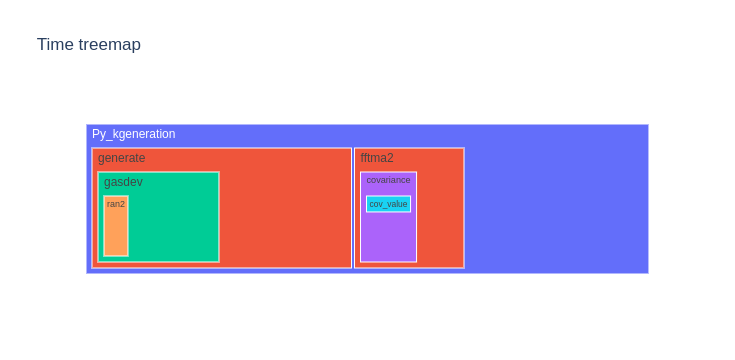

In [126]:
plot_treemap(df)

## N = 64

In [127]:
df = analyze(['log_64-aa', 'log_64-ab'])
df

Executing file log_64-aa
Executing file log_64-ab


memory                        time                          \
                   min     max  median         min         max        mean   
function                                                                     
Py_kgeneration  2781.1  2781.1  2781.1  173.931290  173.931290  173.931290   
generate        2781.2  2781.2  2781.2  137.192987  137.192987  137.192987   
fftma2             2.6     2.6     2.6   36.737828   36.737828   36.737828   
covariance        -1.8    -1.8    -1.8   36.638978   36.638978   36.638978   
gasdev           -54.9    11.1     0.0    0.000076    0.007025    0.000455   
fourt              0.0     2.2     0.0    0.024883    0.040913    0.030275   
cov_value         -7.4     2.0     0.0    0.000086    0.000268    0.000099   
ran2             -17.0     3.4     0.0    0.000075    0.002592    0.000112   
build_real         0.0     0.0     0.0    0.003170    0.003170    0.003170   
prebuild_gwn       2.2     2.2     2.2    0.001027    0.001027    0.001027   
clean_real         0.7     0.7     0.7    0.000707    0.000707    0.000707   
cgrid              0.0     0.0     0.0    0.001641    0.001641    0.001641   
length             0.0     0.0     0.0    0.000310    0.000531    0.000384   
maxfactor          0.0     0.0     0.0    0.000092    0.000094    0.000093   

                                            cpu                          
                       sum     count        min         max        mean  
function                                                                 
Py_kgeneration  173.931290       1.0  19.901069   19.901069  173.931290  
generate        137.192987       1.0  23.489213   23.489213  137.192987  
fftma2           36.737828       1.0   6.498040    6.498040   36.737828  
covariance       36.638978       1.0   6.515506    6.515506   36.638978  
gasdev          101.718838  262144.0   0.000000  100.100000    0.000455  
fourt             0.090826       3.0   0.100000    0.100000    0.030275  
cov_value        15.471843  156816.0   0.000000  100.100000    0.000099  
ran2             31.860609  333450.0   0.000000  100.100000    0.000112  
build_real        0.003170       1.0   0.100000    0.100000    0.003170  
prebuild_gwn      0.001027       1.0   0.000000    0.000000    0.001027  
clean_real        0.000707       1.0   0.000000    0.000000    0.000707  
cgrid             0.001641       1.0   0.000000    0.000000    0.001641  
length            0.001153       3.0   0.000000    0.000000    0.000384  
maxfactor         0.000372       4.0   0.000000    0.000000    0.000093

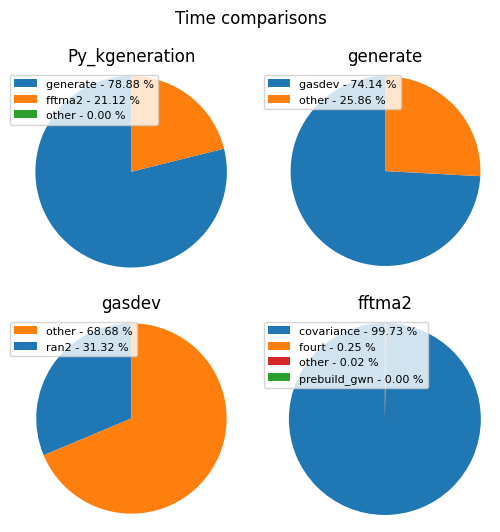

In [128]:
plot_analysis(df)

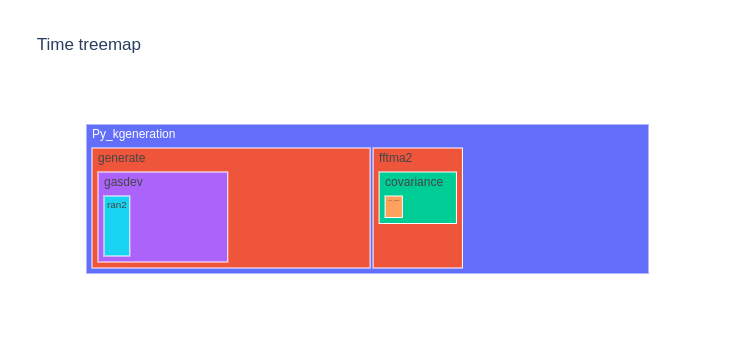

In [129]:
plot_treemap(df)

## N = 128

In [133]:
df = analyze(['log_128-aa', 'log_128-ab', 'log_128-ac', 'log_128-ad', 'log_128-ae', 'log_128-af', 'log_128-ag', 'log_128-ah', 'log_128-ai', 'log_128-aj', 'log_128-ak'])
df

Executing file log_128-aa
Executing file log_128-ab
Executing file log_128-ac
Executing file log_128-ad
Executing file log_128-ae
Executing file log_128-af
Executing file log_128-ag
Executing file log_128-ah
Executing file log_128-ai
Executing file log_128-aj
Executing file log_128-ak


memory                      time                            \
                  min   max median          min          max         mean   
function                                                                    
Py_kgeneration  -14.1 -14.1  -14.1  1530.896938  1530.896938  1530.896938   
generate          3.2   3.2    3.2  1198.768697  1198.768697  1198.768697   
fftma2           -2.8  -2.8   -2.8   332.127615   332.127615   332.127615   
covariance      -20.8 -20.8  -20.8   330.818047   330.818047   330.818047   
gasdev          -81.6   7.4    0.0     0.000081     0.016966     0.000428   
fourt             0.5   1.2    0.6     0.336843     0.525952     0.422136   
cov_value        -9.6   2.7    0.0     0.000102     0.000870     0.000124   
ran2            -12.9   4.8    0.0     0.000078     0.002555     0.000107   
build_real       -0.0  -0.0   -0.0     0.021324     0.021324     0.021324   
prebuild_gwn     17.0  17.0   17.0     0.008650     0.008650     0.008650   
clean_real       14.6  14.6   14.6     0.007677     0.007677     0.007677   
cgrid             0.0   0.0    0.0     0.001930     0.001930     0.001930   
length            0.0   0.0    0.0     0.000410     0.000424     0.000418   
maxfactor         0.0   0.0    0.0     0.000117     0.000119     0.000118   

                                              cpu                           
                        sum      count        min         max         mean  
function                                                                    
Py_kgeneration  1530.896938        1.0  14.870018   14.870018  1530.896938  
generate        1198.768697        1.0  12.167592   12.167592  1198.768697  
fftma2           332.127615        1.0  24.482971   24.482971   332.127615  
covariance       330.818047        1.0  24.492196   24.492196   330.818047  
gasdev           891.863931  2097152.0   0.000000  100.100000     0.000428  
fourt              1.266409        3.0  19.065517   26.290476     0.422136  
cov_value        140.268295  1132300.0   0.000000  100.100000     0.000124  
ran2             282.561512  2668394.0   0.000000  100.100000     0.000107  
build_real         0.021324        1.0   0.100000    0.100000     0.021324  
prebuild_gwn       0.008650        1.0   0.100000    0.100000     0.008650  
clean_real         0.007677        1.0   0.000000    0.000000     0.007677  
cgrid              0.001930        1.0   0.000000    0.000000     0.001930  
length             0.001254        3.0   0.000000    0.000000     0.000418  
maxfactor          0.000354        3.0   0.000000    0.000000     0.000118

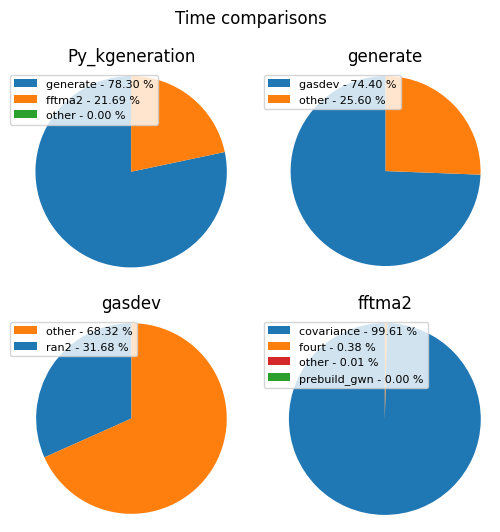

In [134]:
plot_analysis(df)

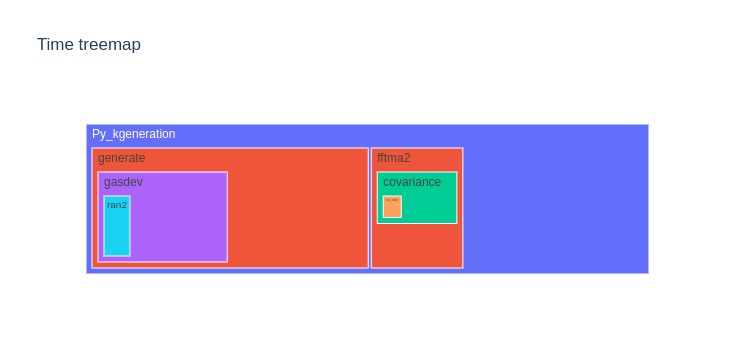

In [135]:
plot_treemap(df)

## N = 256

In [94]:
df = analyze(['log_256-aa', 'log_256-ab', 'log_256-ac'])
df

Executing file number 1 out of 10
Executing file number 2 out of 10
Executing file number 3 out of 10
Executing file number 4 out of 10
Executing file number 5 out of 10
Executing file number 6 out of 10
Executing file number 7 out of 10
Executing file number 8 out of 10
Executing file number 9 out of 10
Executing file number 10 out of 10


In [96]:
merge_dfs(dfs)

memory                        time                            \
                   max  median     min       count          max         mean   
function                                                                       
Py_kgeneration  7421.6  7421.6  7421.6         1.0  1226.822575  1226.822575   
generate        6691.7  6691.7  6691.7         1.0   959.799368   959.799368   
fftma2           872.0   872.0   872.0         1.0   267.021516   267.021516   
covariance       870.5   870.5   870.5         1.0   247.512194   247.512194   
gasdev             8.7     0.0   -13.5  16777216.0     0.001358     0.000033   
fourt             11.5    -1.4   -16.2         3.0     8.429829     6.378454   
cov_value          0.7     0.0   -13.9   8855600.0     0.000437     0.000002   
ran2               0.9     0.0    -0.8  21359556.0     0.000381     0.000002   
build_real        -0.2    -0.2    -0.2         1.0     0.151968     0.151968   
prebuild_gwn       6.5     6.5     6.5         1.0     0.108160     0.108160   
clean_real       127.2   127.2   127.2         1.0     0.095267     0.095267   
cgrid              0.0     0.0     0.0         1.0     0.000160     0.000160   
length             0.0     0.0     0.0         3.0     0.000043     0.000034   
maxfactor          0.0     0.0     0.0         5.0     0.000002     0.000002   

                                          
                        min          sum  
function                                  
Py_kgeneration  1226.822575  1226.822575  
generate         959.799368   959.799368  
fftma2           267.021516   267.021516  
covariance       247.512194   247.512194  
gasdev             0.000000   564.182445  
fourt              5.015006    19.135362  
cov_value          0.000001    21.579349  
ran2               0.000000    45.002553  
build_real         0.151968     0.151968  
prebuild_gwn       0.108160     0.108160  
clean_real         0.095267     0.095267  
cgrid              0.000160     0.000160  
length             0.000021     0.000102  
maxfactor          0.000001     0.000008

In [ ]:
plot_analysis(df)

In [ ]:
plot_treemap(df)

## Function call repetitive times analysed

In [194]:
functions_repeated = {
    "gasdev":["idum", "idum2", "iy"],
    "cov_value": ["di", "dj", "dk"],
    "ran2": ["idum", "idum2", "iy"],
}

def get_data_from_file(file_name):
    data = {
        "gasdev": {"idum": [], "idum2": [], "iy": []},
        "ran2": {"idum": [], "idum2": [], "iy": []},
        "cov_value": {"di":[], "dj": [], "dk": []}
    }

    with open(file_name) as log_file:
        lines = log_file.readlines()
        for line in lines:
            if np.any([f in line for f in functions_repeated.keys()]) and "RESULT = in progress" in line:
                split_line = line.split()
                function_name = get_function_name(split_line[2])
                params = functions_repeated[function_name]
                for p in params:
                    idx_value = split_line.index(p) + 2
                    data[function_name][p].append(float(split_line[idx_value].rsplit(",")[0]))
                #print(split_line)
    return data

def get_repeteated_data(filenames):
    data_total = {}
    for f in filenames:
        data = get_data_from_file(f)
        data_total = {**data_total, **data}
    return data_total

In [248]:
def distribution(data,f, p, plt):
    values = data[f][p]
    if np.isnan(values).all(): return # TODO: Pasa algo raro con gasdev iy en 32
    plt.set_title(f"{p}")
    plt.hist(values, bins=60, alpha=1, edgecolor = 'black',  linewidth=1)
    plt.grid(True)
    plt.set_ylabel("Number of repetitions")
    plt.set_xlabel("value")

def plot_distributions(data, f):
    fig, axs = plt.subplots(2, 2, dpi=100, figsize=(6, 6))
    fig.suptitle(f"Distribution in params for {f}")
    params = list(data[f].keys())
    for i in range(2):
        for j in range(2):
            if 2*i + j < len(params):
                distribution(data, f,params[2*i + j], axs[i, j])
                
    
    fig.delaxes(axs[1, 1])
    fig.tight_layout(pad=3.0)

In [245]:
def plot_reapeated_data_distribution(data):
    for f in functions_repeated.keys():
        plot_distributions(data,f)

## N = 8

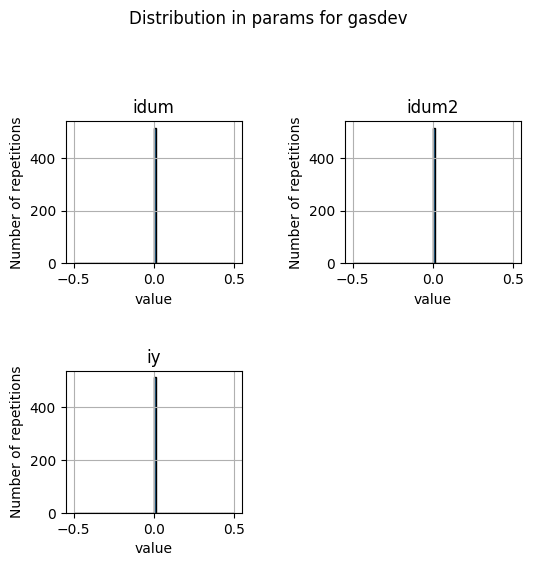

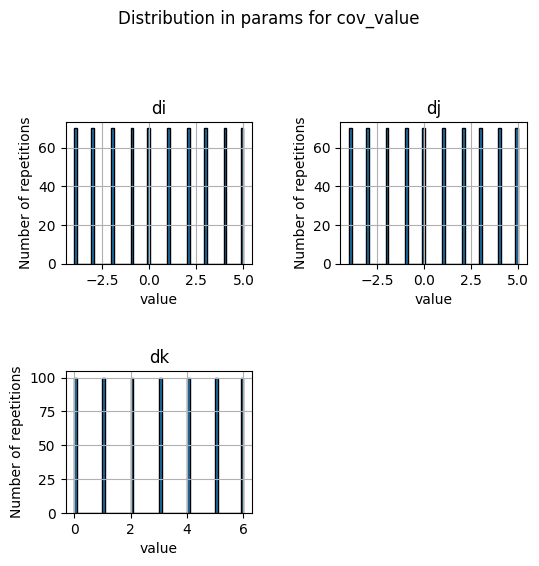

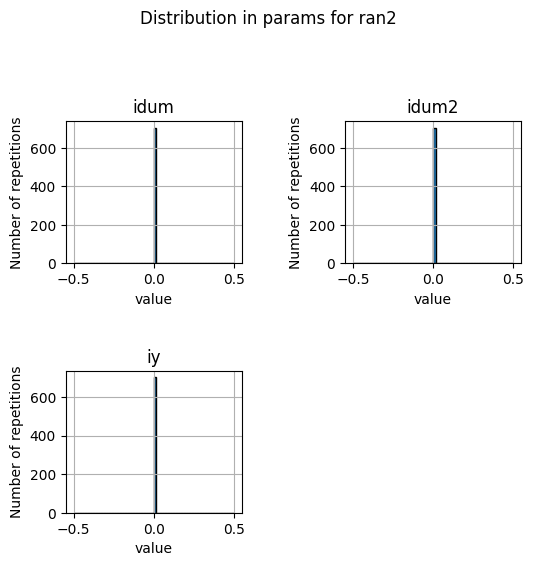

In [234]:
data = get_repeteated_data(['log_8-aa'])
plot_reapeated_data_distribution(data)

## N = 16

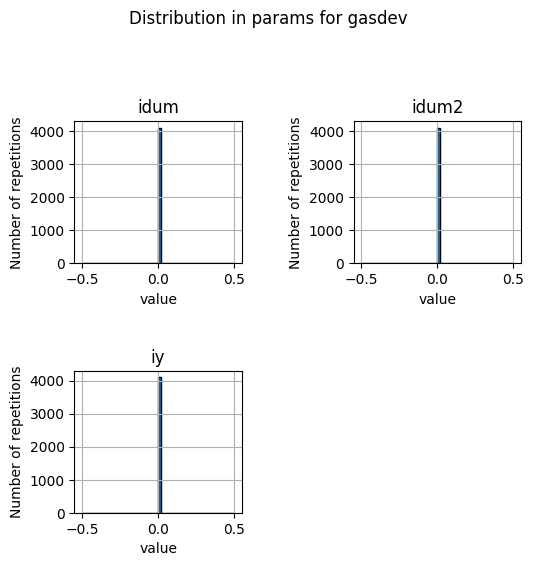

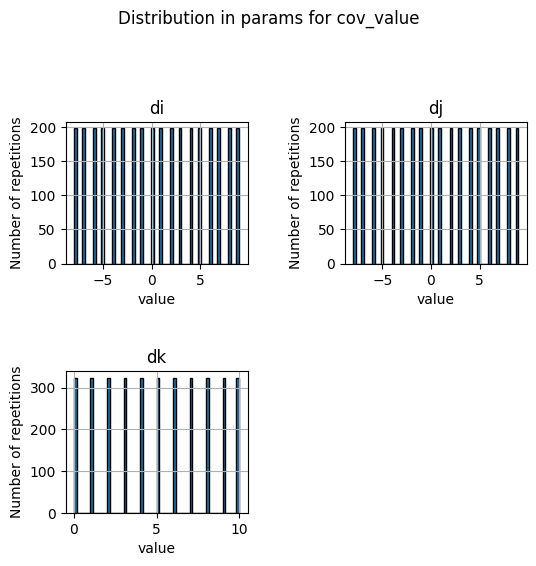

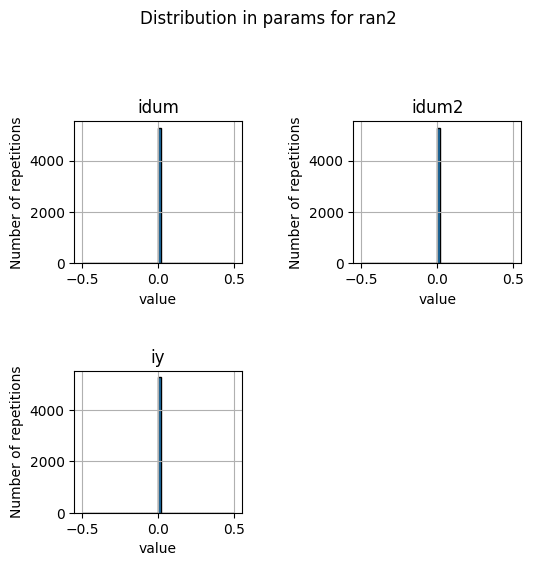

In [235]:
data = get_repeteated_data(['log_16-aa'])
plot_reapeated_data_distribution(data)

## N = 32

gasdev idum
gasdev idum2
gasdev iy
cov_value di
cov_value dj
cov_value dk
ran2 idum
ran2 idum2
ran2 iy


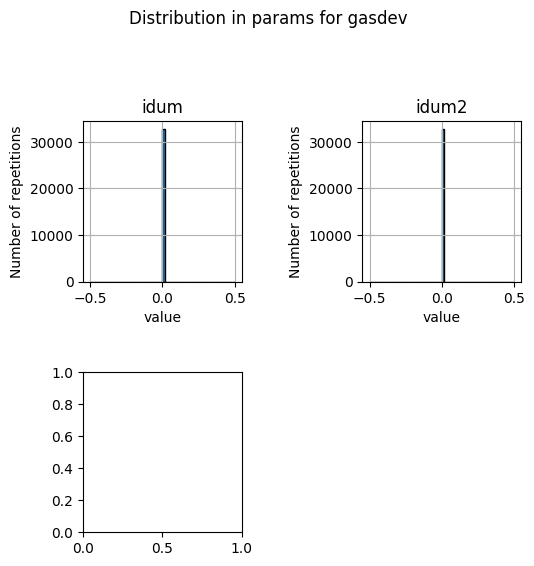

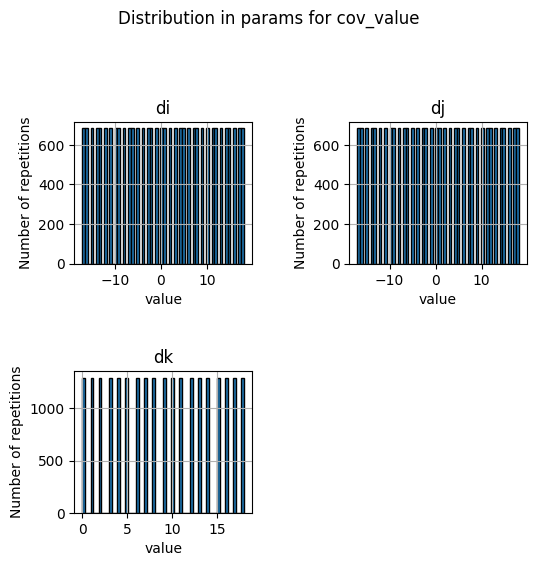

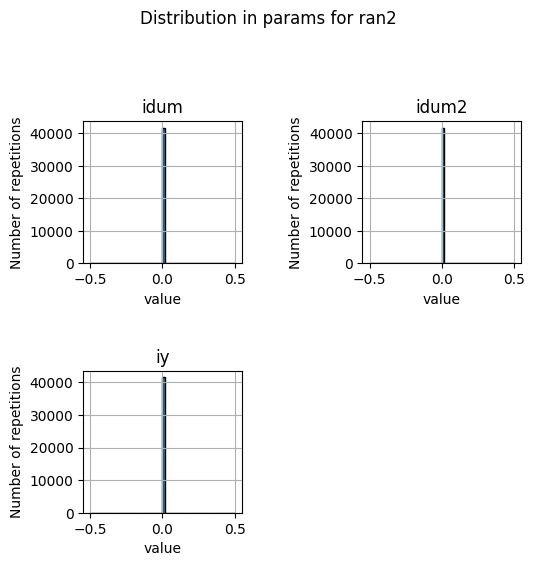

In [246]:
data = get_repeteated_data(['log_32-aa'])
plot_reapeated_data_distribution(data)

## N = 64

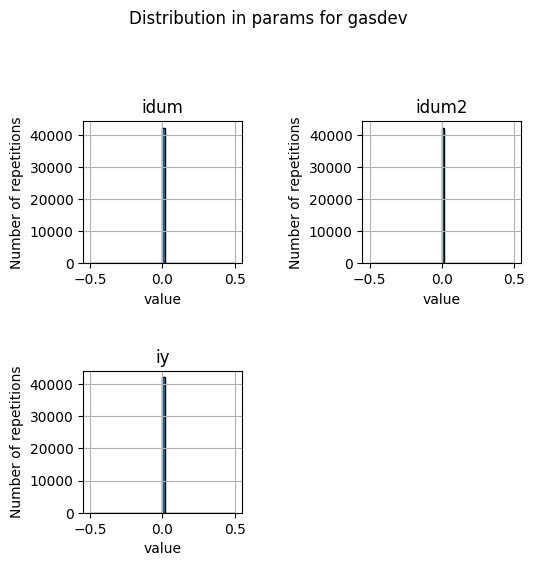

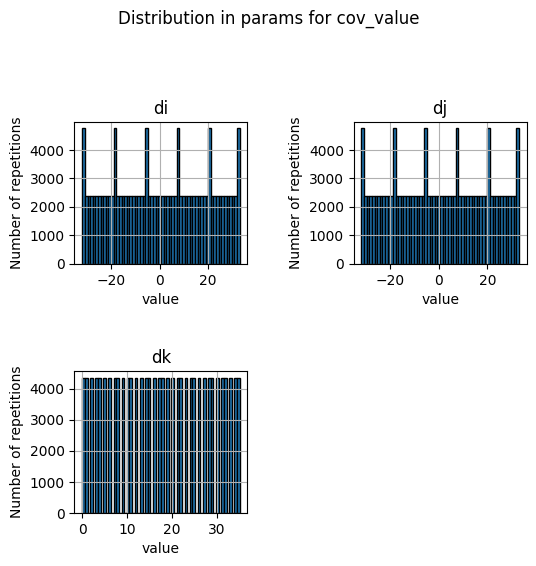

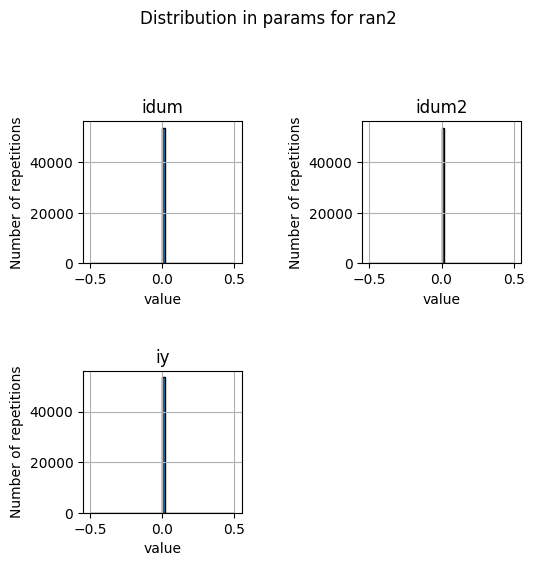

In [249]:
data = get_repeteated_data(['log_64-aa', 'log_64-ab'])
plot_reapeated_data_distribution(data)